In [1]:
!python --version

Python 3.7.16


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.getcwd()
MRCNN_DIR = os.path.join(ROOT_DIR, "Mask-RCNN-TF2")

# Import Mask RCNN
sys.path.append(MRCNN_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(MRCNN_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [3]:
class LesionConfig(Config):
    """Configuration for training on the lesion dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "leison"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + leison

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

    # Image mean (RGB)
    MEAN_PIXEL = np.array([60.20, 49.48, 45.55])

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"
    
config = LesionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
class LesionDataset(utils.Dataset):
    
    def load_lesion(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the datast
        subset: Subset to load: train, val or test
        """
        # Add classes. We have only one class to add.
        self.add_class("lesion", 1, "lesion")
        
        # Train, validation, or test dataset?
        assert subset in ["train", "val", "test", "task3"]
        if subset == "task3":
            subset_path = subset
        else:
            subset_path = os.path.join(subset, "input")
        subset_dir = os.path.join(dataset_dir, subset_path)
        
        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { "fileref": "",
        #   "size": 250000,
        #   "filename": "ISIC_0013258.jpg",
        #   "base64_img_data": "",
        #   "file_attributes": {},
        #   'regions': {
        #       '0': {
        #           'shape_attributes': {
        #               'name': 'polygon'}},
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #           'region_attributes': {},
        #   },
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(subset_dir, "via_region_data.json")))
        annotations = list(annotations.values())
        
        # The VIA tool save images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # Get the x, y coordinates of points of the polygons that make up
            # the outline of each object instance. These are stores in the 
            # shape_attributes (see json format above)
            # The if condiiton is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path=os.path.join(subset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                source="lesion",
                image_id=a['filename'], # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with 
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a isic dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "lesion":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                         dtype=np.uint8)

        def get_polygon_fill_coordinates(x_coords, y_coords):
            if len(x_coords) == 0:
                x_coords, y_coords = [0, 127, 127, 0, 0], [0, 0, 127, 127, 0]
            
            # 다각형 내부의 좌표를 저장할 리스트
            fill_coords = []

            # 다각형의 최소, 최대 y 좌표 계산
            min_y = min(y_coords)
            max_y = max(y_coords)

            # 스캔 라인 알고리즘을 사용하여 내부 좌표 계산
            for y in range(min_y, max_y + 1):
                # 교차하는 점의 x 좌표를 저장할 리스트
                intersect_x = []

                # 다각형의 변을 확인하며 교차하는 점 찾기
                for i in range(len(x_coords)):
                    # 다각형의 한 변의 시작점과 끝점 계산
                    x1, y1 = x_coords[i], y_coords[i]
                    x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

                    # 현재 스캔 라인과 다각형 변이 교차하는지 확인
                    if (y1 <= y < y2) or (y2 <= y < y1):
                        # 교차하는 x 좌표 계산
                        intersect = int(x1 + (y - y1) * (x2 - x1) / (y2 - y1))
                        intersect_x.append(intersect)

                # x 좌표를 정렬하여 짝수 개의 점을 찾아내어 내부 좌표로 추가
                intersect_x.sort()
                for i in range(0, len(intersect_x), 2):
                    for x in range(intersect_x[i], intersect_x[i + 1] + 1):
                        fill_coords.append((x, y))

            return fill_coords

        # tuple 형태의 좌표를 풀어서 두 개의 리스트로 만드는 함수
        def unpack_coordinates(coordinates):
            x_coords = []
            y_coords = []

            for coord in coordinates:
                x, y = coord
                x_coords.append(x)
                y_coords.append(y)

            return x_coords, y_coords

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = p['all_points_y'], p['all_points_x']
            fill_coords = get_polygon_fill_coordinates(rr, cc)
            rr, cc = unpack_coordinates(fill_coords)
            mask[rr, cc, i] = 1
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we areturn an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "lesion":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
LESION_DIR = os.path.join(ROOT_DIR, "resized_datasets_128")

# Training dataset
dataset_train = LesionDataset()
dataset_train.load_lesion(LESION_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = LesionDataset()
dataset_val.load_lesion(LESION_DIR, "val")
dataset_val.prepare()

# Test dataset
dataset_test = LesionDataset()
dataset_test.load_lesion(LESION_DIR, "test")
dataset_test.prepare()

C:\Users\khu\.conda\envs\isic\lib\site-packages\ipykernel_launcher.py:143: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


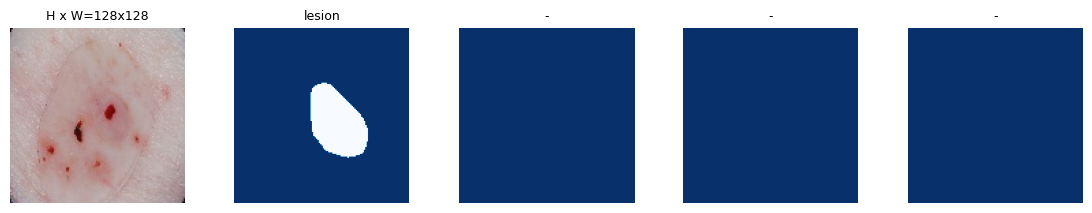

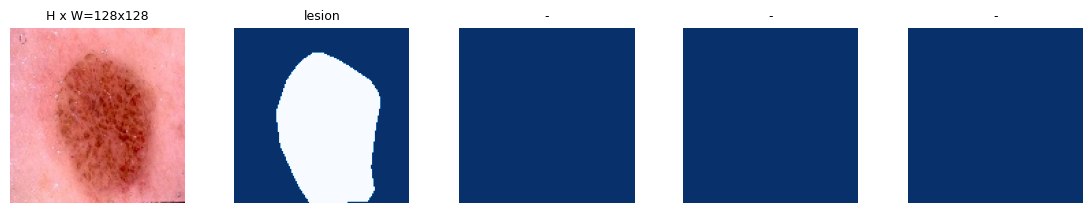

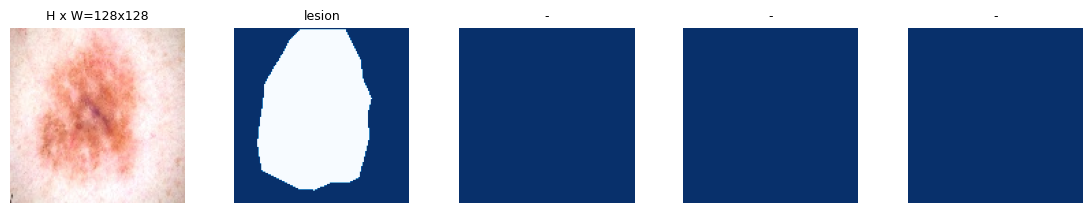

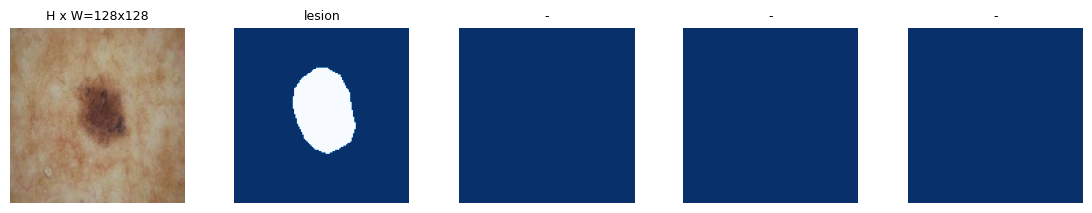

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\khu\Desktop\ISIC\Mask-RCNN-TF2\logs\leison20230608T1412\mask_rcnn_leison_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

C:\Users\khu\.conda\envs\isic\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 33s 331ms/step - loss: 1.8941 - val_loss: 0.8995


In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=50, 
            layers="all", 
           custom_callbacks=[early_stopping])


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\khu\Desktop\ISIC\Mask-RCNN-TF2\logs\leison20230608T1412\mask_rcnn_leison_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

C:\Users\khu\.conda\envs\isic\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/50
  2/100 [..............................] - ETA: 12:07 - loss: 1.4447

C:\Users\khu\.conda\envs\isic\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (13.784351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 75s 753ms/step - loss: 1.2734 - val_loss: 1.8952
Epoch 3/50
100/100 [==============================] - 32s 325ms/step - loss: 1.3413 - val_loss: 0.6965
Epoch 4/50
100/100 [==============================] - 31s 308ms/step - loss: 1.2389 - val_loss: 1.6484
Epoch 5/50
100/100 [==============================] - 29s 291ms/step - loss: 1.0822 - val_loss: 1.5559
Epoch 6/50
100/100 [==============================] - 28s 281ms/step - loss: 1.3859 - val_loss: 1.5053
Epoch 7/50
100/100 [==============================] - 28s 279ms/step - loss: 1.1439 - val_loss: 0.3928
Epoch 8/50
100/100 [==============================] - 28s 276ms/step - loss: 1.0933 - val_loss: 0.6782
Epoch 9/50
100/100 [==============================] - 27s 268ms/step - loss: 1.0414 - val_loss: 0.7928
Epoch 10/50
100/100 [==============================] - 26s 264ms/step - loss: 1.0571 - val_loss: 1.5410
Epoch 11/50
100/100 [==============================] - 27s 268ms/step - loss: 1.137

No handles with labels found to put in legend.


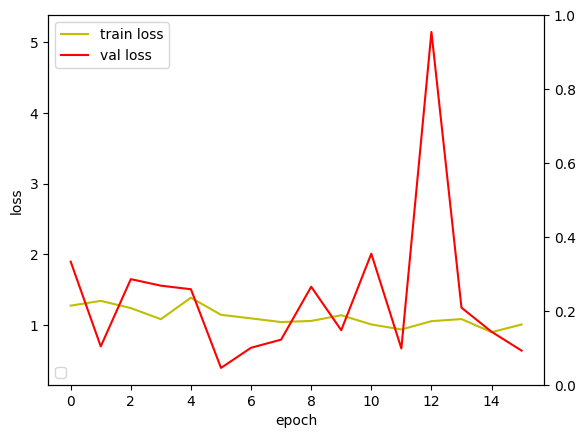

In [13]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(model.history.history['loss'], 'y', label='train loss')
loss_ax.plot(model.history.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(model.history.history['accuracy'], 'b', label='train acc')
#acc_ax.plot(model.history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_lesion_128_50_10.h5")
model.keras_model.save_weights(model_path)

In [15]:
class InferenceConfig(LesionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\khu\Desktop\ISIC\Mask-RCNN-TF2\logs\leison20230608T1412\mask_rcnn_leison_0017.h5
Re-starting from epoch 17


In [61]:
original_image

array([[[148, 144, 107],
        [149, 145, 108],
        [151, 147, 109],
        ...,
        [147, 144, 109],
        [145, 141, 106],
        [142, 138, 103]],

       [[148, 144, 107],
        [147, 143, 106],
        [147, 143, 105],
        ...,
        [148, 145, 110],
        [146, 142, 107],
        [144, 140, 105]],

       [[151, 147, 110],
        [151, 147, 110],
        [147, 143, 106],
        ...,
        [148, 145, 110],
        [148, 144, 109],
        [148, 144, 109]],

       ...,

       [[145, 135, 100],
        [146, 136, 101],
        [147, 137, 102],
        ...,
        [151, 145, 113],
        [151, 145, 113],
        [152, 146, 114]],

       [[143, 133,  98],
        [147, 137, 102],
        [152, 142, 107],
        ...,
        [151, 145, 113],
        [150, 144, 112],
        [151, 145, 113]],

       [[146, 136, 101],
        [148, 138, 103],
        [152, 142, 107],
        ...,
        [153, 147, 115],
        [150, 144, 112],
        [151, 145, 113]]

original_image           shape: (128, 128, 3)         min:   23.00000  max:  206.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   46.00000  max:  114.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


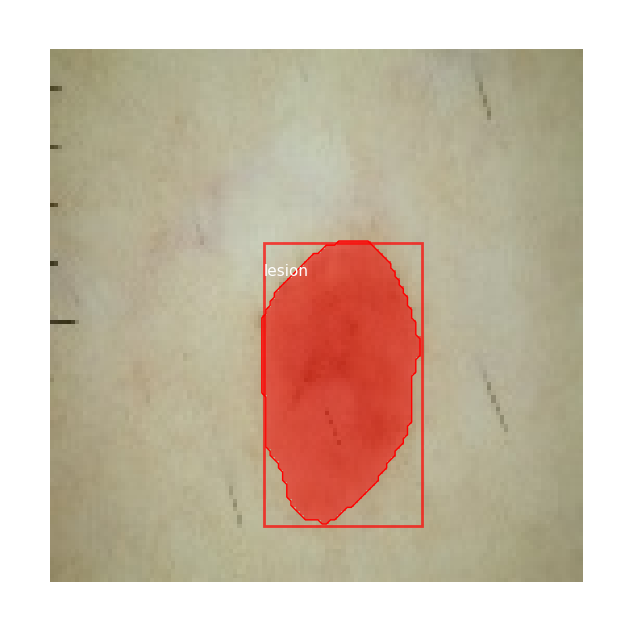

In [16]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   23.00000  max:  206.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -22.55000  max:  156.52000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


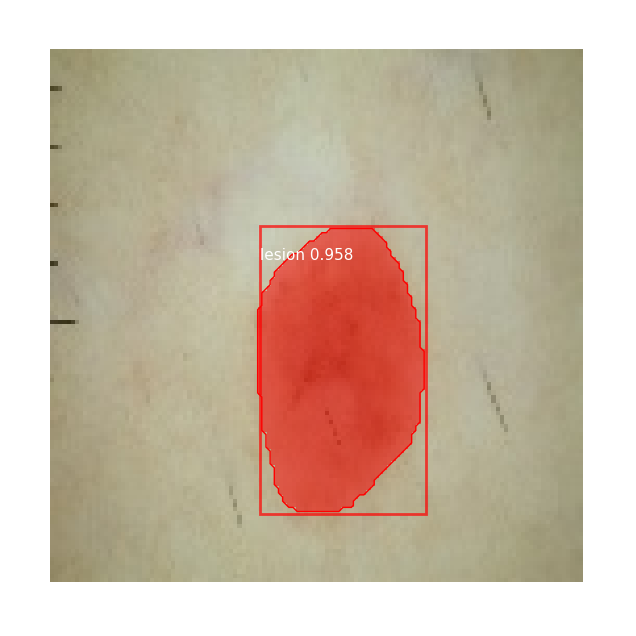

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_test.image_ids, 10)
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.915


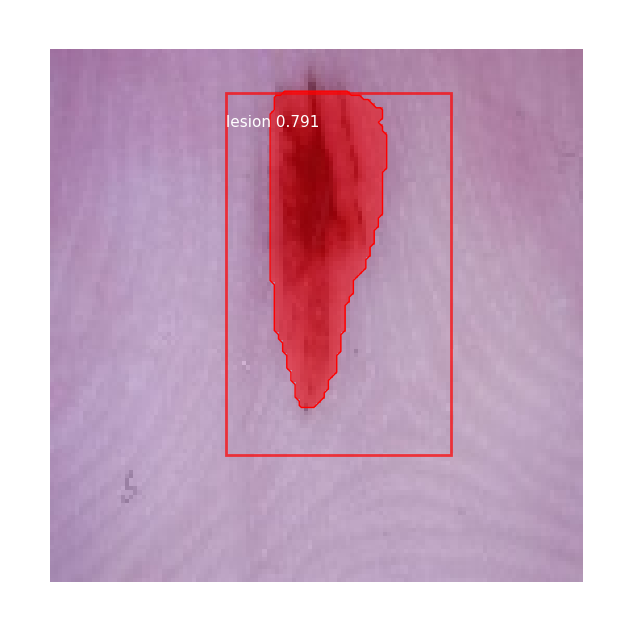

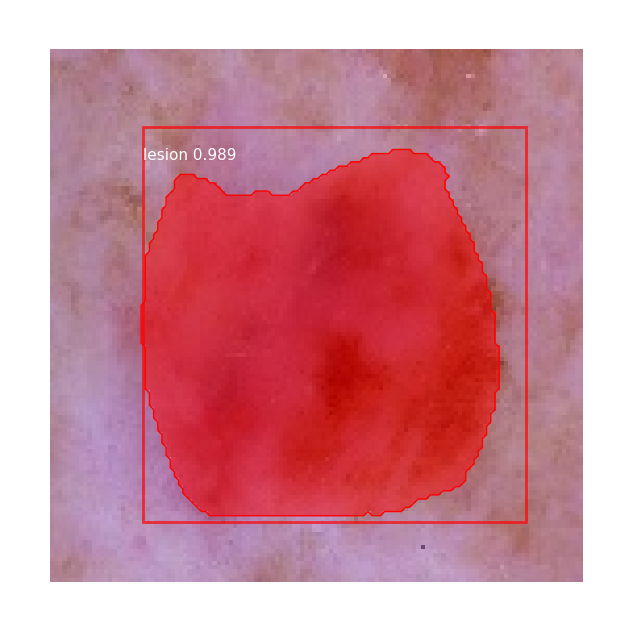

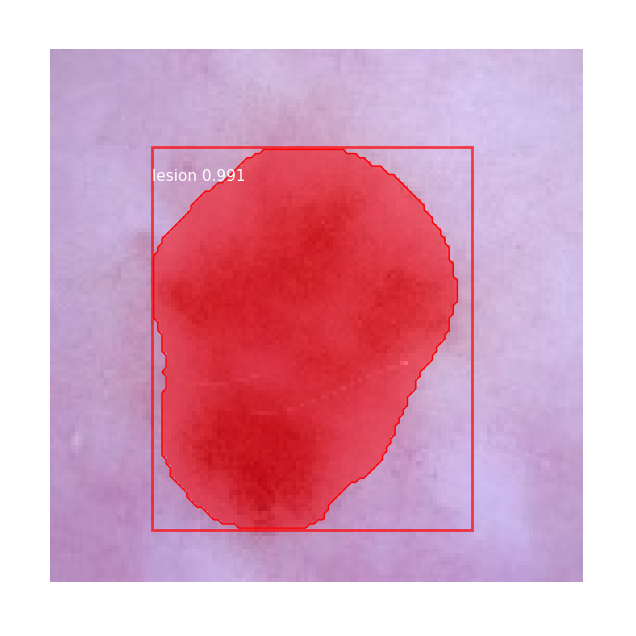

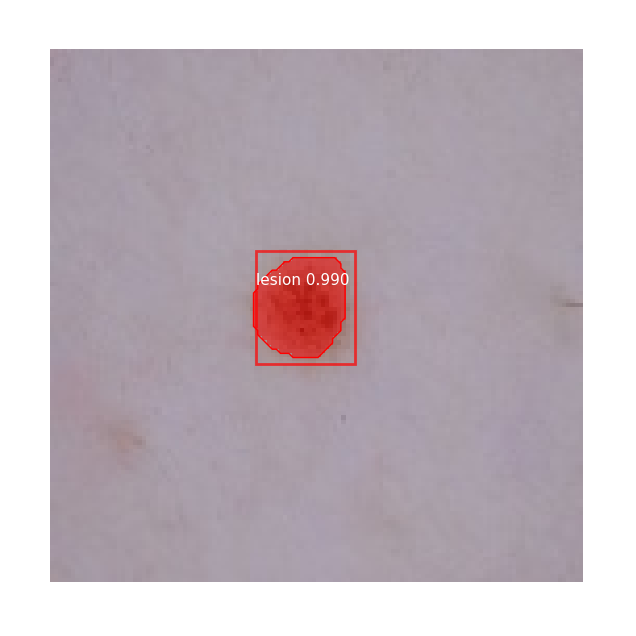

In [19]:
# task3 dataset에 대한 mask detection 결과 시각화
CLASS_NAMES = ['BG', 'lesion']

TASK3_DIR = os.path.join(ROOT_DIR, 'task3_128')
folder_path = os.path.join(TASK3_DIR, 'val')
image_names = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        image_names.append(file_name)

random_images = np.random.choice(image_names, 4)

for image_path in random_images:
    image = cv2.imread(os.path.join(folder_path, image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model.detect([image], verbose=0)

    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                CLASS_NAMES, r['scores'], ax=get_ax())

In [20]:
import os
import cv2
import shutil
import random
import pandas as pd
import numpy as np
from collections import Counter
import imgaug.augmenters as iaa
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# Classification
class Task3_Dataset:
    
    def __init__(self, subset):
        self.subset = subset  
        self.X = []
        self.y = []
        
    def prepare(self, save=False, printing=True):
        ROOT_DIR = os.getcwd()
        
        def print_shape(X, y):
            print("Shape of X:", X.shape)
            print("Shape of y:", y.shape)
            print()
        
        
        def load_dataset():
            DATASET_DIR = os.path.join(ROOT_DIR, "task3_128")

            csv_file = self.subset + "_y.csv"
            print("Loading " + self.subset + " data...", end=" ")
            csv_path = os.path.join(DATASET_DIR, csv_file)
            df = pd.read_csv(csv_path)

            # 이미지 폴더 경로
            image_folder = os.path.join(DATASET_DIR, self.subset)

            # 분류 모델 생성을 위한 데이터 준비
            X = []
            y = []

            # 이미지 파일과 클래스 레이블 반복 처리
            for index, row in df.iterrows():
                image_name = row["image"]
                image_full_name = image_name + '.jpg'
                image_path = os.path.join(image_folder, image_full_name)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                X.append(image)

                y_temp = []
                for label, value in row[1:].items():
                    y_temp.append(int(value))
                y.append(y_temp)

            print("Done!\n")

            X = np.array(X)
            y = np.array(y)

            return X, y


        def balance_data(X, y):
            print("Augmenting data...", end=' ')
            
            # 각 레이블 별 데이터 수 계산
            n_labels = y.shape[1]
            counts = [0] * n_labels
            for elem in y:
                counts[elem.tolist().index(1)] += 1

            # 이미지 증강 기법 설정
            augmenter = iaa.Sequential([
                iaa.Fliplr(0.5),  # 좌우 반전
                iaa.Affine(rotate=(-45, 45)),  # 회전
                iaa.GaussianBlur(sigma=(0, 1.0)),  # 가우시안 블러
                iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # 가우시안 노이즈 추가
            ])

            # 이미지 데이터의 개수
            n_samples = X.shape[0]

            # 각 레이블에 대한 데이터 수 계산
            max_count = np.max(counts)

            # 이미지 데이터 증강
            X_augmented = []
            y_augmented = []

            # 각 레이블에 대해 증강된 이미지 개수 맞추기
            for label, count in enumerate(counts):
                indices = np.where(y[:, label] == 1)[0]
                np.random.shuffle(indices)
                selected_indices = indices[:count]

                while len(selected_indices) < max_count:
                    random_index = np.random.choice(indices)
                    selected_indices = np.append(selected_indices, random_index)

                for index in selected_indices:
                    image = X[index]
                    label = y[index]

                    augmented_image = augmenter(image=image)
                    X_augmented.append(augmented_image)
                    y_augmented.append(label)

            # 리스트를 배열로 변환
            X_augmented = np.array(X_augmented, dtype=np.uint8)
            y_augmented = np.array(y_augmented, dtype=np.uint8)
            
            print("Done!\n")

            # 증강된 이미지 데이터와 레이블 데이터 출력
            print("Before Augmentation:", counts, "-> Total:", sum(counts))
            aug_counts = Counter(np.where(y_augmented == 1)[1])
            aug_counts = [count for _, count in sorted(aug_counts.items())]
            print("After Augmentation:", aug_counts, "-> Total:", sum(aug_counts))
            print()

            print("Augmented X shape:", X_augmented.shape)
            print("Augmented y shape:", y_augmented.shape)
            print()
            
            if save == True:
                AUGMENTED_DIR = os.path.join(ROOT_DIR, "augmented_128")
                os.makedirs(AUGMENTED_DIR, exist_ok=True)
                image_folder = os.path.join(AUGMENTED_DIR, self.subset)
                os.makedirs(image_folder, exist_ok=True)

                print("Saving augmented images...", end=" ")
                for index, image in enumerate(X_augmented):
                    image = Image.fromarray(image)
                    image_file = str(index) + '.jpg'
                    image_path = os.path.join(image_folder, image_file)
                    image.save(image_path)
                print("Done!\n")

            return X_augmented, y_augmented


        def extract_bounding_boxes(X_augmented, y_augmented):
            print("Detecting bounding boxes...", end=" ")
            
            X_cropped = []
            y_cropped = []

            for i in range(len(X_augmented)):
                image = X_augmented[i]
                results = model.detect([image], verbose=0)
                r = results[0]

                # 가장 높은 점수의 bounding box 선택
                if r['rois'].shape[0] > 0:
                    highest_score_index = np.argmax(r['scores'])
                    bbox = r['rois'][highest_score_index]
                    y1, x1, y2, x2 = bbox
                    cropped_image = image[y1:y2, x1:x2]
                    X_cropped.append(cropped_image)
                    y_cropped.append(y_augmented[i])
                    
            print("Done!\n")

            if save == True:
                print("Saving cropped images...", end=" ")
                CROPPED_DIR = os.path.join(ROOT_DIR, "cropped_128")
                os.makedirs(CROPPED_DIR, exist_ok=True)
                image_folder = os.path.join(CROPPED_DIR, self.subset)
                os.makedirs(image_folder, exist_ok=True)
                for index, image in enumerate(X_cropped):
                    image = Image.fromarray(image)
                    image_file = str(index) + '.jpg'
                    image_path = os.path.join(image_folder, image_file)
                    image.save(image_path)
                print("Done!\n")
            
            y_cropped = np.array(y_cropped, dtype=np.uint8)

            return X_cropped, y_cropped # X_cropped는 각 이미지의 크기가 다르기 때문에 numpy 배열로 바꿀 수 없음


        def preprocess(X_cropped):
            print("Preprocessing images...", end=' ')
            
            X_preprocessed = []
            
            for image in X_cropped:
                resized_image = cv2.resize(image, (128, 128))
                X_preprocessed.append(resized_image)
                
            print("Done!\n")

            if save == True:
                print("Saving preprocessed images...", end=" ")
                PREPROCESSED_DIR = os.path.join(ROOT_DIR, "preprocessed_128")
                os.makedirs(PREPROCESSED_DIR, exist_ok=True)
                image_folder = os.path.join(PREPROCESSED_DIR, self.subset)
                os.makedirs(image_folder, exist_ok=True)
                for index, image in enumerate(X_preprocessed):
                    image = Image.fromarray(image)
                    image_file = str(index) + '.jpg'
                    image_path = os.path.join(image_folder, image_file)
                    image.save(image_path)
                print("Done!\n")

            # 이미지 크기를 [0, 1] 범위로 정규화
            X_preprocessed = np.array(X_preprocessed).astype('float32') / 255.0

            return X_preprocessed
        
        
        X, y = load_dataset()
        if printing:
            print_shape(X, y)
            
        X_augmented, y_augmented = balance_data(X, y)
            
        X_cropped, y_cropped = extract_bounding_boxes(X_augmented, y_augmented)
        if printing:
            print("Shape of X:", len(X_cropped))
            print("Shape of y:", y_cropped.shape)
            print()
            
        X_preprocessed = preprocess(X_cropped)
        if printing:
            print_shape(X_preprocessed, y_cropped)
        
        self.X = X_preprocessed
        self.y = y_cropped
        
        return X_preprocessed, y_cropped
    
    def save_csv(self):
        n = len(self.X)
        print("X_" + self.subset + ":", self.X.shape)
        csv_name = "X_" + self.subset + ".csv"
        print("Creating " + csv_name + "... ", end='')

        X_flattened = self.X.reshape(n, -1)
        df_X = pd.DataFrame(X_flattened)
        df_X.to_csv(os.path.join(ROOT_DIR, csv_name), index=False)
        print("Done!")
        
        n = len(self.y)
        print("y_" + self.subset + ":", self.y.shape)
        csv_name = "y_" + self.subset + ".csv"
        print("Creating " + csv_name + "... ", end='')

        y_flattened = self.y.reshape(n, -1)
        df_y = pd.DataFrame(y_flattened)
        df_y.to_csv(os.path.join(ROOT_DIR, csv_name), index=False)
        print("Done!\n")
        
    def load_csv(self, n):
        ROOT_DIR = os.getcwd()
        csv_name = "X_" + self.subset + ".csv"
        print("Loading " + csv_name + "... ", end='')
        df_X = pd.read_csv(os.path.join(ROOT_DIR, csv_name), header=0)
        X_flattened = df_X.values
        X = X_flattened.reshape(n, 128, 128, 3)
        self.X = X.astype(np.float32)
        print("Done!")
        
        csv_name = "y_" + self.subset + ".csv"
        print("Loading " + csv_name + "... ", end='')
        df_y = pd.read_csv(os.path.join(ROOT_DIR, csv_name), header=0)
        y_flattened = df_y.values
        y = y_flattened.reshape(n, 7)
        self.y = y
        print("Done!\n")
        
        return self.X, self.y
    

In [11]:
train = Task3_Dataset("train")
val = Task3_Dataset("val")
test = Task3_Dataset("test")

X_train, y_train = train.prepare(save=True)
X_val, y_val = val.prepare(save=True)
X_test, y_test = test.prepare(save=True)

Loading train data... Done!

Shape of X: (10015, 128, 128, 3)
Shape of y: (10015, 7)

Augmenting data... Done!

Before Augmentation: [1113, 6705, 514, 327, 1099, 115, 142] -> Total: 10015
After Augmentation: [6705, 6705, 6705, 6705, 6705, 6705, 6705] -> Total: 46935

Augmented X shape: (46935, 128, 128, 3)
Augmented y shape: (46935, 7)

Saving augmented images... Done!

Detecting bounding boxes... Done!

Saving cropped images... Done!

Shape of X: 46687
Shape of y: (46687, 7)

Preprocessing images... Done!

Saving preprocessed images... Done!

Shape of X: (46687, 128, 128, 3)
Shape of y: (46687, 7)

Loading val data... Done!

Shape of X: (193, 128, 128, 3)
Shape of y: (193, 7)

Augmenting data... Done!

Before Augmentation: [21, 123, 15, 8, 22, 1, 3] -> Total: 193
After Augmentation: [123, 123, 123, 123, 123, 123, 123] -> Total: 861

Augmented X shape: (861, 128, 128, 3)
Augmented y shape: (861, 7)

Saving augmented images... Done!

Detecting bounding boxes... Done!

Saving cropped ima

In [20]:
train.save_csv()
val.save_csv()
test.save_csv()

X_train: (46687, 128, 128, 3)
Creating X_train.csv... Done!
y_train: (46687, 7)
Saving y as y_train.csv... Done!

X_val: (854, 128, 128, 3)
Creating X_val.csv... Done!
y_val: (854, 7)
Saving y as y_val.csv... Done!

X_test: (6350, 128, 128, 3)
Creating X_test.csv... Done!
y_test: (6350, 7)
Saving y as y_test.csv... Done!



In [23]:
train = Task3_Dataset("train")
val = Task3_Dataset("val")
test = Task3_Dataset("test")

X_train, y_train = train.load_csv(46729)
X_val, y_val = val.load_csv(852)
X_test, y_test = test.load_csv(6347)

Loading X_train.csv... Done!
Loading y_train.csv... Done!

Loading X_val.csv... Done!
Loading y_val.csv... Done!

Loading X_test.csv... Done!
Loading y_test.csv... Done!



In [32]:
from sklearn.model_selection import train_test_split

X_tv, X_test, y_tv, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, stratify=y_tv, random_state=123)

In [45]:
# DenseNet121 (w/o pre-trained weights) ver.
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = 7

# 모델 생성
base_model = DenseNet121(weights=None, include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
dmodel = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
dmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 훈련
hist = dmodel.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
468/468 [==============================] - 151s 322ms/step - loss: 1.1960 - accuracy: 0.5362 - val_loss: 2.1650 - val_accuracy: 0.3215
Epoch 2/100
468/468 [==============================] - 145s 310ms/step - loss: 0.9968 - accuracy: 0.6180 - val_loss: 1.7736 - val_accuracy: 0.4771
Epoch 3/100
468/468 [==============================] - 146s 313ms/step - loss: 0.8575 - accuracy: 0.6739 - val_loss: 1.9272 - val_accuracy: 0.4466
Epoch 4/100
468/468 [==============================] - 147s 314ms/step - loss: 0.7567 - accuracy: 0.7129 - val_loss: 2.8877 - val_accuracy: 0.4000
Epoch 5/100
468/468 [==============================] - 146s 311ms/step - loss: 0.6819 - accuracy: 0.7397 - val_loss: 1.1478 - val_accuracy: 0.6347
Epoch 6/100
468/468 [==============================] - 146s 311ms/step - loss: 0.6245 - accuracy: 0.7634 - val_loss: 1.3108 - val_accuracy: 0.6068
Epoch 7/100
468/468 [==============================] - 146s 312ms/step - loss: 0.5550 - accuracy: 0.7903 - val_loss: 0

In [47]:
# 모델 평가
test_loss, test_accuracy = dmodel.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

TASK3_MODEL_DIR = os.path.join(ROOT_DIR, "task3_model")
dmodel.save(os.path.join(TASK3_MODEL_DIR, "task3_d121_01.h5"))

293/293 [==============================] - 14s 47ms/step - loss: 1.4065 - accuracy: 0.76120s - loss: 1.3948 - 
Test Loss: 1.4065, Test Accuracy: 0.7612


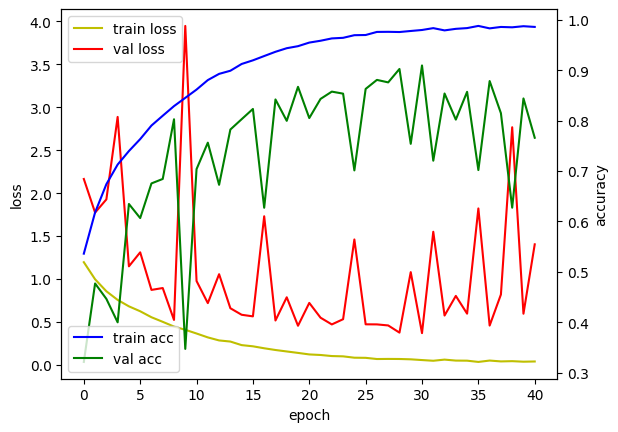

In [48]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [35]:
# Xception w/ pre-trained weights
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7

# Xception 모델 불러오기 (pre-trained weights 사용)
base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

# 새로운 Fully Connected 계층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # 예시로 128 차원의 은닉층 추가
predictions = Dense(num_classes, activation='softmax')(x)  # 분류할 클래스 수에 맞는 출력층 추가

# 전체 모델 구성
xmodel = Model(inputs=base_model.input, outputs=predictions)

# 기존의 가중치들을 동결하여 학습되지 않도록 설정 (Fine-tuning을 원하는 경우 일부 레이어만 동결 해제 가능)
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
xmodel.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_x = xmodel.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
935/935 [==============================] - 69s 74ms/step - loss: 1.1934 - accuracy: 0.5522 - val_loss: 1.0376 - val_accuracy: 0.6159
Epoch 2/100
935/935 [==============================] - 68s 73ms/step - loss: 0.9477 - accuracy: 0.6417 - val_loss: 0.9656 - val_accuracy: 0.6380
Epoch 3/100
935/935 [==============================] - 68s 73ms/step - loss: 0.8318 - accuracy: 0.6871 - val_loss: 0.8944 - val_accuracy: 0.6630
Epoch 4/100
935/935 [==============================] - 69s 74ms/step - loss: 0.7364 - accuracy: 0.7216 - val_loss: 0.8826 - val_accuracy: 0.6697
Epoch 5/100
935/935 [==============================] - 69s 73ms/step - loss: 0.6583 - accuracy: 0.7534 - val_loss: 0.8500 - val_accuracy: 0.6849
Epoch 6/100
935/935 [==============================] - 69s 74ms/step - loss: 0.5948 - accuracy: 0.7780 - val_loss: 0.8524 - val_accuracy: 0.6931
Epoch 7/100
935/935 [==============================] - 69s 74ms/step - loss: 0.5357 - accuracy: 0.8021 - val_loss: 0.8389 - val_ac

In [36]:
# 모델 평가
test_loss, test_accuracy = xmodel.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

TASK3_MODEL_DIR = os.path.join(ROOT_DIR, "task3_model")
xmodel.save(os.path.join(TASK3_MODEL_DIR, "task3_x_01.h5"))

293/293 [==============================] - 18s 60ms/step - loss: 1.1530 - accuracy: 0.7005
Test Loss: 1.1530, Test Accuracy: 0.7005


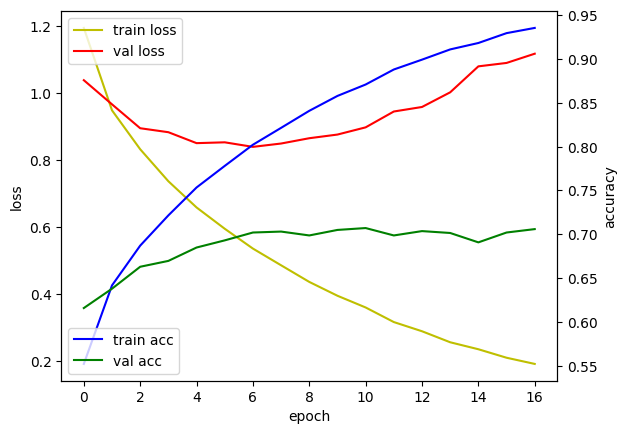

In [37]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_x.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_x.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist_x.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist_x.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [38]:
# Xception w/o pre-trained weights
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 7

# Xception 모델 생성
base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

# 새로운 Fully Connected 계층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # 예시로 128 차원의 은닉층 추가
predictions = Dense(num_classes, activation='softmax')(x)  # 분류할 클래스 수에 맞는 출력층 추가

# 전체 모델 구성
xmodel = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
xmodel.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_x = xmodel.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
935/935 [==============================] - 221s 237ms/step - loss: 1.2290 - accuracy: 0.5293 - val_loss: 1.5193 - val_accuracy: 0.5038
Epoch 2/100
935/935 [==============================] - 221s 236ms/step - loss: 0.8938 - accuracy: 0.6677 - val_loss: 0.8477 - val_accuracy: 0.6820
Epoch 3/100
935/935 [==============================] - 222s 237ms/step - loss: 0.7299 - accuracy: 0.7291 - val_loss: 1.1793 - val_accuracy: 0.5926
Epoch 4/100
935/935 [==============================] - 221s 236ms/step - loss: 0.6236 - accuracy: 0.7680 - val_loss: 1.0397 - val_accuracy: 0.6372
Epoch 5/100
935/935 [==============================] - 221s 236ms/step - loss: 0.5398 - accuracy: 0.7981 - val_loss: 0.7936 - val_accuracy: 0.7102
Epoch 6/100
935/935 [==============================] - 221s 236ms/step - loss: 0.4590 - accuracy: 0.8300 - val_loss: 0.6806 - val_accuracy: 0.7506
Epoch 7/100
935/935 [==============================] - 221s 237ms/step - loss: 0.3898 - accuracy: 0.8549 - val_loss: 0

In [39]:
# 모델 평가
test_loss, test_accuracy = xmodel.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

TASK3_MODEL_DIR = os.path.join(ROOT_DIR, "task3_model")
xmodel.save(os.path.join(TASK3_MODEL_DIR, "task3_x_02.h5"))

293/293 [==============================] - 17s 59ms/step - loss: 0.5987 - accuracy: 0.8599
Test Loss: 0.5987, Test Accuracy: 0.8599


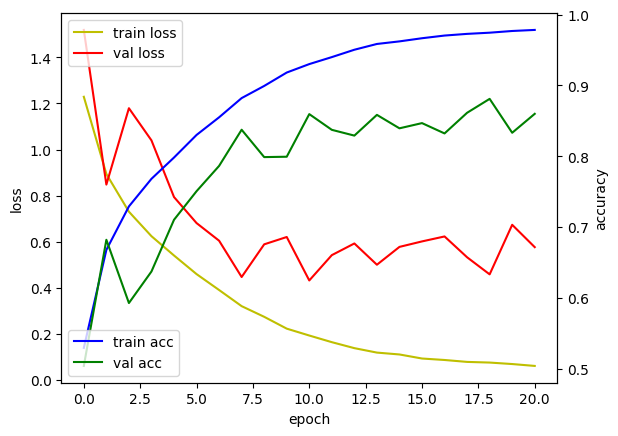

In [40]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_x.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_x.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist_x.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist_x.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()